In [1]:
# import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import math
from scipy.spatial import distance
import scipy
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

mnist = input_data.read_data_sets('minst_data/')

train_images = np.asarray(mnist.train.images[:50000])
train_labels = np.asarray(mnist.train.labels[:50000])
test_images = np.asarray(mnist.test.images[:100])
test_labels = np.asarray(mnist.test.labels[:100])

print("Done Loading images as train and test")

Extracting minst_data/train-images-idx3-ubyte.gz
Extracting minst_data/train-labels-idx1-ubyte.gz
Extracting minst_data/t10k-images-idx3-ubyte.gz
Extracting minst_data/t10k-labels-idx1-ubyte.gz
Done Loading images as train and test


In [3]:
train_data = []
for i in range(len(train_images)):
    train_data.append([train_labels[i], train_images[i]])
print("Done creating train data")

Done creating train data


In [4]:
training_size = int(len(train_data)*0.25)
validation = train_data[:training_size]
training = train_data[training_size:]
print("Done creating training and validation sets")

Done creating training and validation sets


In [5]:
def check_twos():
    twos = []
    frequency = {x:0 for x in range(10)}

    for (label,digit) in validation:
        inferred_label = classify_digit(digit, labelled_centroids)
        if inferred_label==2:
            twos.append(digit)
            frequency[label] +=1
            
    print(frequency)

In [6]:
import matplotlib.pyplot as plt
def display_digit(digit, labeled = True, title = ""):
    if labeled:
        digit = digit[1]
    image = digit.reshape(28,28)
    plt.figure()
    fig = plt.imshow(image.reshape(28,28))
    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    if title != "":
        plt.title("Inferred label: " + str(title))
    plt.show()
        
        
def show_digits(centroids):

    for i in range(len(centroids)):
        image = centroids[i]
        fig = plt.imshow(image.reshape(28,28))
        fig.set_cmap('gray_r')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False) 
        
        plt.show()

In [7]:
import random
def init_centroids(labelled_data,k):
    return map(lambda x: x[1], random.sample(labelled_data,k))
k = 10

In [8]:
def sum_cluster(labelled_cluster):
    sum_ = labelled_cluster[0][1].copy()
    for (label,vector) in labelled_cluster[1:]:
        sum_ += vector
    return sum_

def mean_cluster(labelled_cluster):
    sum_of_points = sum_cluster(labelled_cluster)
    mean_of_points = sum_of_points * (1.0 / len(labelled_cluster))
    return mean_of_points

In [141]:
def get_dict(cluster):
    d = dict()
    for j in range(len(cluster)):
        label = cluster[j][0]
        if label in d:
            d[label] += 1
        else:
            d[label] = 1
#     print(d)
    return d

In [142]:
def form_clusters(labelled_data, unlabelled_centroids):
    change = 0
    centroids_indices = range(len(unlabelled_centroids))
    clusters = {c: [] for c in centroids_indices}
    for (label,Xi) in labelled_data:
        smallest_distance = float("inf")
        for cj_index in centroids_indices:
            cj = unlabelled_centroids[cj_index]
            distance = np.linalg.norm(Xi - cj)
            if distance < smallest_distance:
                closest_centroid_index = cj_index
                smallest_distance = distance
        
        clusters[closest_centroid_index].append((label,Xi))
    return clusters.values()

In [143]:
def move_centroids(labelled_clusters):
    new_centroids = []
    for cluster in labelled_clusters:
        new_centroids.append(mean_cluster(cluster))
    return new_centroids

In [144]:
def get_dict_difference(d1, d2):
#     print("##################Dictionaries 1:", d1)
#     print("##################Dictionaries 2:", d2)
    
    difference = 0
    for i,j in zip(d1, d2):
        for a,b in zip(i,j):
            difference += (abs(a-b))
    print ("Diff: ", difference/2)
    return difference/2

In [150]:
def repeat_until_convergence(labelled_data, labelled_clusters, unlabelled_centroids):
    previous_max_difference = 100000
    iter = 0
    max_iter = 50
    dict_prev = []
    dict_curr = []
    while iter < max_iter:
        iter += 1
        print ("Updating centroids ", iter)
        unlabelled_old_centroids = unlabelled_centroids
        unlabelled_centroids = move_centroids(labelled_clusters)
        labelled_clusters = form_clusters(labelled_data, unlabelled_centroids)
#         print("Gini for ",iter, " is: ", get_gini_index(labelled_clusters))
#         print("Purity for ",iter, " is: ", get_purity(labelled_clusters)) 
    
        for cluster in labelled_clusters:
            dict_curr.append(get_dict(cluster))
        if iter != 1:
            change = get_dict_difference(dict_prev, dict_curr)
            if change == 0:
                print("Break 2")
                break
        dict_prev = dict_curr
        dict_curr = []
        # keep old_clusters and clusters so we can get the maximum difference
        # between centroid positions every time.
        differences = map(lambda a, b: np.linalg.norm(a-b),unlabelled_old_centroids,unlabelled_centroids)
        max_difference = max(differences)
        print("max difference: ", max_difference)
        print("-----------------------------------")
        difference_change = abs((max_difference-previous_max_difference)/np.mean([previous_max_difference,max_difference])) * 100
        previous_max_difference = max_difference
        if np.isnan(difference_change):
            print("Break 2")
            break
    return labelled_clusters, unlabelled_centroids

In [146]:
def cluster(labelled_data, k):
    centroids = list(init_centroids(labelled_data, k))
    clusters = form_clusters(labelled_data, centroids)
    final_clusters, final_centroids = repeat_until_convergence(labelled_data, clusters, centroids)
    print ("Exiting cluster function")
    return final_clusters, final_centroids

In [131]:
import itertools
import operator

def most_common(L):
    SL = sorted((x, i) for i, x in enumerate(L))
    groups = itertools.groupby(SL, key=operator.itemgetter(0))
    def _auxfun(g):
        item, iterable = g
        count = 0
        min_index = len(L)
        for _, where in iterable:
            count += 1
            min_index = min(min_index, where)
        return count, -min_index
    return max(groups, key=_auxfun)[0]


def assign_labels_to_centroids(clusters, centroids):
    labelled_centroids = []
    clusters = list(clusters)
    for i in range(len(clusters)):
        labels = []
        for k in clusters[i]:
            labels.append(k[0])
        common = most_common(labels)
        centroid = (common, centroids[i])
        labelled_centroids.append(centroid)
    return labelled_centroids

In [132]:
def classify_digit(digit, labelled_centroids):
    mindistance = float("inf")
    for (label, centroid) in labelled_centroids:
        distance = np.linalg.norm(centroid - digit)
        if distance < mindistance:
            mindistance = distance
            closest_centroid_label = label
    return closest_centroid_label

def get_error_rate(labelled_digits,labelled_centroids):
    classified_incorrect = 0
    for (label,digit) in labelled_digits:
        classified_label = classify_digit(digit, labelled_centroids)
        if classified_label != label:
            classified_incorrect +=1
    error_rate = classified_incorrect / float(len(training))
    return error_rate

In [133]:
import math
def calculate_gini_index(d,size):
    val = 0.0
    for label in d:
        val += math.pow((d[label]/size), 2)
    return 1 - val    

In [134]:
def get_gini_index(clusters):
    size = []
    gini_index = []
    for cluster in clusters:
        d = get_dict(cluster)
        l = len(cluster)
        size.append(l)
        gini_index.append(calculate_gini_index(d,l))
    g_index = 0
    for i in range(len(clusters)):
        g_index += gini_index[i]*size[i]
    return g_index/len(training)
        

In [135]:
def get_purity(clusters):
    size = []
    purity = []
    for cluster in clusters:
        d = get_dict(cluster)
        l = len(cluster)
        size.append(l)
        purity.append(max(list(d.values())))

    return sum(purity)/len(training)

In [152]:
def kmeans(k):
    clusters, centroids = cluster(training, k)
    g = get_gini_index(clusters)
    print("Calculating purity")
    purity = get_purity(clusters)
    print(purity)
#     labelled_centroids = assign_labels_to_centroids(clusters, centroids)
#     gini_index = get_gini_index(list(clusters), labelled_centroids)
#     error_rate = get_error_rate(training, labelled_centroids)
    return purity, g 

Performing KMeans for k = 5
Updating centroids  1
Gini for  1  is:  0.8028585115930106
Purity for  1  is:  0.3147466666666667
max difference:  6.69178
-----------------------------------
Updating centroids  2
Gini for  2  is:  0.7704238866201071
Purity for  2  is:  0.35072
Diff:  1408.0
max difference:  1.27814
-----------------------------------
Updating centroids  3


C:\Users\Jay\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in ubyte_scalars
  


Gini for  3  is:  0.7542453160914527
Purity for  3  is:  0.3709866666666667
Diff:  1152.0
max difference:  0.777198
-----------------------------------
Updating centroids  4
Gini for  4  is:  0.7462272284609756
Purity for  4  is:  0.38248
Diff:  256.0
max difference:  0.432845
-----------------------------------
Updating centroids  5
Gini for  5  is:  0.738631446028818
Purity for  5  is:  0.39213333333333333
Diff:  256.0
max difference:  0.333136
-----------------------------------
Updating centroids  6
Gini for  6  is:  0.7299525488716719
Purity for  6  is:  0.4013333333333333
Diff:  768.0
max difference:  0.370229
-----------------------------------
Updating centroids  7
Gini for  7  is:  0.7210556506309033
Purity for  7  is:  0.40954666666666667
Diff:  512.0
max difference:  0.344333
-----------------------------------
Updating centroids  8
Gini for  8  is:  0.7131865386900126
Purity for  8  is:  0.41712
Diff:  128.0
max difference:  0.33165
-----------------------------------
Updat

Updating centroids  1
Gini for  1  is:  0.7066379401088886
Purity for  1  is:  0.4424
max difference:  6.84573
-----------------------------------
Updating centroids  2
Gini for  2  is:  0.6694591294620323
Purity for  2  is:  0.4843733333333333
Diff:  3065.0
max difference:  1.30178
-----------------------------------
Updating centroids  3
Gini for  3  is:  0.6396992627452542
Purity for  3  is:  0.51232
Diff:  1286.0
max difference:  1.11195
-----------------------------------
Updating centroids  4
Gini for  4  is:  0.6112006016217488
Purity for  4  is:  0.5360533333333334
Diff:  1408.0
max difference:  0.930019
-----------------------------------
Updating centroids  5
Gini for  5  is:  0.5865749803208696
Purity for  5  is:  0.5539733333333333
Diff:  2048.0
max difference:  0.632556
-----------------------------------
Updating centroids  6
Gini for  6  is:  0.5762712720551713
Purity for  6  is:  0.56088
Diff:  256.0
max difference:  0.650099
-----------------------------------
Updating

Gini for  1  is:  0.7174869928119662
Purity for  1  is:  0.40997333333333336
max difference:  5.64671
-----------------------------------
Updating centroids  2
Gini for  2  is:  0.6892145091942998
Purity for  2  is:  0.44154666666666664
Diff:  4737.5
max difference:  1.23794
-----------------------------------
Updating centroids  3
Gini for  3  is:  0.6613291241829135
Purity for  3  is:  0.47768
Diff:  3069.0
max difference:  1.04888
-----------------------------------
Updating centroids  4
Gini for  4  is:  0.6207018148968659
Purity for  4  is:  0.5145066666666667
Diff:  2563.0
max difference:  2.30637
-----------------------------------
Updating centroids  5
Gini for  5  is:  0.5980753165794054
Purity for  5  is:  0.5348
Diff:  1667.0
max difference:  1.54284
-----------------------------------
Updating centroids  6
Gini for  6  is:  0.580102397524983
Purity for  6  is:  0.5510933333333333
Diff:  2304.0
max difference:  0.562234
-----------------------------------
Updating centroids 

Gini for  11  is:  0.505598647421278
Purity for  11  is:  0.61624
Diff:  1280.0
max difference:  0.231591
-----------------------------------
Updating centroids  12
Gini for  12  is:  0.5037977890121493
Purity for  12  is:  0.6210666666666667
Diff:  640.0
max difference:  0.243825
-----------------------------------
Updating centroids  13
Gini for  13  is:  0.5025798961205538
Purity for  13  is:  0.6252
Diff:  896.0
max difference:  0.212697
-----------------------------------
Updating centroids  14
Gini for  14  is:  0.5007592773552485
Purity for  14  is:  0.6290666666666667
Diff:  896.0
max difference:  0.198717
-----------------------------------
Updating centroids  15
Gini for  15  is:  0.4996145090361518
Purity for  15  is:  0.6313066666666667
Diff:  384.0
max difference:  0.168257
-----------------------------------
Updating centroids  16
Gini for  16  is:  0.4986432826539069
Purity for  16  is:  0.6330133333333333
Diff:  896.0
max difference:  0.131734
--------------------------

Gini for  8  is:  0.4788013726233663
Purity for  8  is:  0.6468266666666667
Diff:  1405.0
max difference:  0.440948
-----------------------------------
Updating centroids  9
Gini for  9  is:  0.4774537400569824
Purity for  9  is:  0.6477333333333334
Diff:  1661.5
max difference:  0.368356
-----------------------------------
Updating centroids  10
Gini for  10  is:  0.4765249728859569
Purity for  10  is:  0.6480266666666666
Diff:  1024.0
max difference:  0.435699
-----------------------------------
Updating centroids  11
Gini for  11  is:  0.4764991524436837
Purity for  11  is:  0.6487466666666667
Diff:  640.0
max difference:  0.463397
-----------------------------------
Updating centroids  12
Gini for  12  is:  0.4767448596770108
Purity for  12  is:  0.6490666666666667
Diff:  1152.0
max difference:  0.413267
-----------------------------------
Updating centroids  13
Gini for  13  is:  0.4769904719012704
Purity for  13  is:  0.64888
Diff:  1920.0
max difference:  0.301436
--------------

Gini for  2  is:  0.5881797994900028
Purity for  2  is:  0.53704
Diff:  6016.0
max difference:  1.28366
-----------------------------------
Updating centroids  3
Gini for  3  is:  0.5717765047944232
Purity for  3  is:  0.54976
Diff:  3204.5
max difference:  0.711606
-----------------------------------
Updating centroids  4
Gini for  4  is:  0.5646386648202804
Purity for  4  is:  0.5564
Diff:  2688.0
max difference:  0.578104
-----------------------------------
Updating centroids  5
Gini for  5  is:  0.5604511222393928
Purity for  5  is:  0.56184
Diff:  2560.0
max difference:  0.662816
-----------------------------------
Updating centroids  6
Gini for  6  is:  0.5555176652486767
Purity for  6  is:  0.56584
Diff:  2176.0
max difference:  0.838505
-----------------------------------
Updating centroids  7
Gini for  7  is:  0.5480906530378199
Purity for  7  is:  0.57384
Diff:  1920.0
max difference:  0.911914
-----------------------------------
Updating centroids  8
Gini for  8  is:  0.5401

Gini for  9  is:  0.46235267108112216
Purity for  9  is:  0.6552
Diff:  2304.0
max difference:  0.333223
-----------------------------------
Updating centroids  10
Gini for  10  is:  0.4589874296664734
Purity for  10  is:  0.6573866666666667
Diff:  642.0
max difference:  0.284153
-----------------------------------
Updating centroids  11
Gini for  11  is:  0.45681522354069076
Purity for  11  is:  0.6584266666666667
Diff:  1152.0
max difference:  0.235244
-----------------------------------
Updating centroids  12
Gini for  12  is:  0.4559077252540224
Purity for  12  is:  0.6586133333333334
Diff:  1024.0
max difference:  0.185424
-----------------------------------
Updating centroids  13
Gini for  13  is:  0.45544699390765947
Purity for  13  is:  0.6583466666666666
Diff:  896.0
max difference:  0.159643
-----------------------------------
Updating centroids  14
Gini for  14  is:  0.4547465828669011
Purity for  14  is:  0.6588533333333333
Diff:  1024.0
max difference:  0.156234
----------

Gini for  14  is:  0.4365001330527617
Purity for  14  is:  0.6734133333333333
Diff:  1664.0
max difference:  0.572624
-----------------------------------
Updating centroids  15
Gini for  15  is:  0.4311595003218047
Purity for  15  is:  0.6792266666666666
Diff:  2304.0
max difference:  0.559209
-----------------------------------
Updating centroids  16
Gini for  16  is:  0.4261052978107838
Purity for  16  is:  0.6845333333333333
Diff:  385.5
max difference:  0.485789
-----------------------------------
Updating centroids  17
Gini for  17  is:  0.42123306397197874
Purity for  17  is:  0.68936
Diff:  2816.0
max difference:  0.327321
-----------------------------------
Updating centroids  18
Gini for  18  is:  0.4164798987146102
Purity for  18  is:  0.6930666666666667
Diff:  896.5
max difference:  0.325784
-----------------------------------
Updating centroids  19
Gini for  19  is:  0.4118859361702272
Purity for  19  is:  0.6961333333333334
Diff:  1789.5
max difference:  0.282324
---------

Gini for  14  is:  0.41782040799038284
Purity for  14  is:  0.6918933333333334
Diff:  894.5
max difference:  0.314647
-----------------------------------
Updating centroids  15
Gini for  15  is:  0.41676119595267264
Purity for  15  is:  0.6924266666666666
Diff:  762.5
max difference:  0.218834
-----------------------------------
Updating centroids  16
Gini for  16  is:  0.41581470272349697
Purity for  16  is:  0.6930666666666667
Diff:  642.5
max difference:  0.184155
-----------------------------------
Updating centroids  17
Gini for  17  is:  0.41503681907970763
Purity for  17  is:  0.6937333333333333
Diff:  258.5
max difference:  0.143999
-----------------------------------
Updating centroids  18
Gini for  18  is:  0.41392290745897187
Purity for  18  is:  0.69432
Diff:  384.0
max difference:  0.154098
-----------------------------------
Updating centroids  19
Gini for  19  is:  0.4115218000754673
Purity for  19  is:  0.696
Diff:  384.0
max difference:  0.179755
----------------------

Updating centroids  1
Gini for  1  is:  0.5259187804641886
Purity for  1  is:  0.6003733333333333
max difference:  6.23599
-----------------------------------
Updating centroids  2
Gini for  2  is:  0.49520901147686913
Purity for  2  is:  0.6259733333333334
Diff:  5124.0
max difference:  1.5405
-----------------------------------
Updating centroids  3
Gini for  3  is:  0.475389042470588
Purity for  3  is:  0.6439733333333333
Diff:  5247.0
max difference:  1.10283
-----------------------------------
Updating centroids  4
Gini for  4  is:  0.4600508568830423
Purity for  4  is:  0.65792
Diff:  3074.5
max difference:  0.887297
-----------------------------------
Updating centroids  5
Gini for  5  is:  0.4444135796243931
Purity for  5  is:  0.6728266666666667
Diff:  4093.0
max difference:  0.886329
-----------------------------------
Updating centroids  6
Gini for  6  is:  0.42822166649523147
Purity for  6  is:  0.6852
Diff:  3583.5
max difference:  0.724698
--------------------------------

Gini for  9  is:  0.4066024574524876
Purity for  9  is:  0.7016533333333334
Diff:  1413.5
max difference:  0.27102
-----------------------------------
Updating centroids  10
Gini for  10  is:  0.40542583544949184
Purity for  10  is:  0.7030666666666666
Diff:  1280.5
max difference:  0.256033
-----------------------------------
Updating centroids  11
Gini for  11  is:  0.40503803197347493
Purity for  11  is:  0.70352
Diff:  763.5
max difference:  0.262891
-----------------------------------
Updating centroids  12
Gini for  12  is:  0.4034648387163274
Purity for  12  is:  0.7049866666666667
Diff:  642.0
max difference:  0.271645
-----------------------------------
Updating centroids  13
Gini for  13  is:  0.40194733439472397
Purity for  13  is:  0.70568
Diff:  1280.0
max difference:  0.306271
-----------------------------------
Updating centroids  14
Gini for  14  is:  0.4017969633982174
Purity for  14  is:  0.7054933333333333
Diff:  2304.0
max difference:  0.318547
---------------------

Gini for  24  is:  0.386478584060957
Purity for  24  is:  0.7260266666666667
Diff:  130.0
max difference:  0.094714
-----------------------------------
Updating centroids  25
Gini for  25  is:  0.3865306683922298
Purity for  25  is:  0.7261066666666667
Diff:  1152.0
max difference:  0.0713257
-----------------------------------
Updating centroids  26
Gini for  26  is:  0.3865478614307533
Purity for  26  is:  0.72616
Diff:  128.0
max difference:  0.0752492
-----------------------------------
Updating centroids  27
Gini for  27  is:  0.3866572910828549
Purity for  27  is:  0.72616
Diff:  0.0
Break 2
Exiting cluster function
Calculating purity
0.72616
Performing KMeans for k = 26
Updating centroids  1
Gini for  1  is:  0.5037033761672809
Purity for  1  is:  0.61792
max difference:  6.44438
-----------------------------------
Updating centroids  2
Gini for  2  is:  0.46428516728972297
Purity for  2  is:  0.6492266666666666
Diff:  9600.0
max difference:  1.53076
----------------------------

Gini for  17  is:  0.2124249828718886
Purity for  17  is:  0.8636
Diff:  2937.0
max difference:  0.313473
-----------------------------------
Updating centroids  18
Gini for  18  is:  0.21223908809623993
Purity for  18  is:  0.8639466666666666
Diff:  1662.0
max difference:  0.262696
-----------------------------------
Updating centroids  19
Gini for  19  is:  0.21188412344395868
Purity for  19  is:  0.8644
Diff:  2948.0
max difference:  0.294659
-----------------------------------
Updating centroids  20
Gini for  20  is:  0.2114897890574045
Purity for  20  is:  0.8648
Diff:  1410.5
max difference:  0.335795
-----------------------------------
Updating centroids  21
Gini for  21  is:  0.2116088552723679
Purity for  21  is:  0.86472
Diff:  642.5
max difference:  0.230718
-----------------------------------
Updating centroids  22
Gini for  22  is:  0.21138701689221676
Purity for  22  is:  0.8648266666666666
Diff:  1410.5
max difference:  0.168613
-----------------------------------
Updati

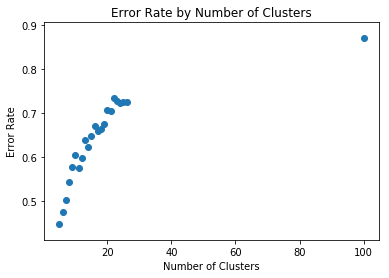

In [153]:
all_k = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,100]
error_rates = []
gini_rates = []
for k in all_k:
    print("Performing KMeans for k =", k)
    e_rate, gini_val = kmeans(k)
    error_rates.append(e_rate)
    gini_rates.append(gini_val)
print(error_rates)

x_axis = all_k
y_axis = error_rates
plt.figure()
plt.title("Error Rate by Number of Clusters")
plt.scatter(x_axis, y_axis)
plt.xlabel("Number of Clusters")
plt.ylabel("Error Rate")
plt.show()

In [151]:
gini, val = kmeans(10)
print(gini)

Updating centroids  1
Gini for  1  is:  0.7221280944010519
Purity for  1  is:  0.39048
max difference:  5.89211
-----------------------------------
Updating centroids  2
Gini for  2  is:  0.6701252405327945
Purity for  2  is:  0.4612
Diff:  3582.5
max difference:  1.63258
-----------------------------------
Updating centroids  3


C:\Users\Jay\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in ubyte_scalars
  


Gini for  3  is:  0.6300014283958185
Purity for  3  is:  0.5030666666666667
Diff:  3456.0
max difference:  1.42015
-----------------------------------
Updating centroids  4
Gini for  4  is:  0.606117852241215
Purity for  4  is:  0.5262933333333333
Diff:  1920.0
max difference:  0.846286
-----------------------------------
Updating centroids  5
Gini for  5  is:  0.5937147269115887
Purity for  5  is:  0.53712
Diff:  1536.0
max difference:  0.451023
-----------------------------------
Updating centroids  6
Gini for  6  is:  0.5852076761849501
Purity for  6  is:  0.54376
Diff:  1152.0
max difference:  0.372755
-----------------------------------
Updating centroids  7
Gini for  7  is:  0.5802739870846826
Purity for  7  is:  0.5468
Diff:  512.0
max difference:  0.317371
-----------------------------------
Updating centroids  8
Gini for  8  is:  0.5766455605372759
Purity for  8  is:  0.54896
Diff:  640.0
max difference:  0.236518
-----------------------------------
Updating centroids  9
Gini 